<a href="https://colab.research.google.com/github/AbiyaMakruf/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Test save from colab to github

In [ ]:
#Mendownload dataset
!gdown 1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp

#Melakukan unzip file dataset
!unzip -q Dataset_TugasAkhir.zip

#Menghapus file zip
!rm -rf Dataset_TugasAkhir.zip

#Menghapus file tidak dibutuhkan
!rm -rf sample_data

Downloading...
From (original): https://drive.google.com/uc?id=1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp
From (redirected): https://drive.google.com/uc?id=1txRjjMdgVyb45G6yqzfGjiGHCb44oOYp&confirm=t&uuid=3069468e-40c1-4b4c-9206-4de09039c764
To: /content/Dataset_TugasAkhir.zip
100% 864M/864M [00:19<00:00, 43.4MB/s]


In [ ]:
# Import library yang digunakan untuk keseluruhan dataset
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import model arsitektur dan preprocess input untuk MobileNet dan EfficientNet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess

In [ ]:
# Path ke folder dataset utama
dataset_utama = 'dataset_utama'
dataset_splitted = 'dataset'  # Folder tujuan untuk menyimpan train, validation, test
categories = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Membuat folder train, validation, dan test jika belum ada
for folder in ['train', 'validation', 'test']:
    for category in categories:
        os.makedirs(os.path.join(dataset_splitted, folder, category), exist_ok=True)

# Fungsi untuk membagi file
def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.8, 0.05, 0.15)):
    files = os.listdir(source_dir)
    files = [f for f in files if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)

    # Hitung jumlah file untuk setiap split
    train_size = int(split_ratio[0] * len(files))
    val_size = int(split_ratio[1] * len(files))

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Pindahkan file ke folder train
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))

    # Pindahkan file ke folder validation
    for file in val_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(val_dir, file))

    # Pindahkan file ke folder test
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Bagi setiap kategori (healthy, multiple_diseases, rust, scab)
for category in categories:
    source_dir = os.path.join(dataset_utama, category)
    train_dir = os.path.join(dataset_splitted, 'train', category)
    val_dir = os.path.join(dataset_splitted, 'validation', category)
    test_dir = os.path.join(dataset_splitted, 'test', category)

    split_data(source_dir, train_dir, val_dir, test_dir)

print("Pembagian dataset selesai.")

Pembagian dataset selesai.


In [ ]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'validation')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

# Contoh penggunaan untuk EfficientNetB0
base_path = "dataset/"

# Pilih fungsi preprocessing yang sesuai dengan model
preprocess_input_func = efficientnet_preprocess

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=(528, 528),
    batch_size=32,
    preprocess_input_func=preprocess_input_func
)

Found 2912 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 550 images belonging to 4 classes.


In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.4748 - loss: 1.1415 - val_accuracy: 0.7444 - val_loss: 0.7077
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.7104 - loss: 0.7674 - val_accuracy: 0.8167 - val_loss: 0.5469
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.7733 - loss: 0.6423 - val_accuracy: 0.8389 - val_loss: 0.4890
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8026 - loss: 0.5726 - val_accuracy: 0.8667 - val_loss: 0.4231
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.8169 - loss: 0.5454 - val_accuracy: 0.8778 - val_loss: 0.3776
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.8231 - loss: 0.5339 - val_accuracy: 0.8667 - val_loss: 0.3780
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8242 - loss: 0.5095 - val_accuracy: 0.8833 - val_loss: 0.3731
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accur

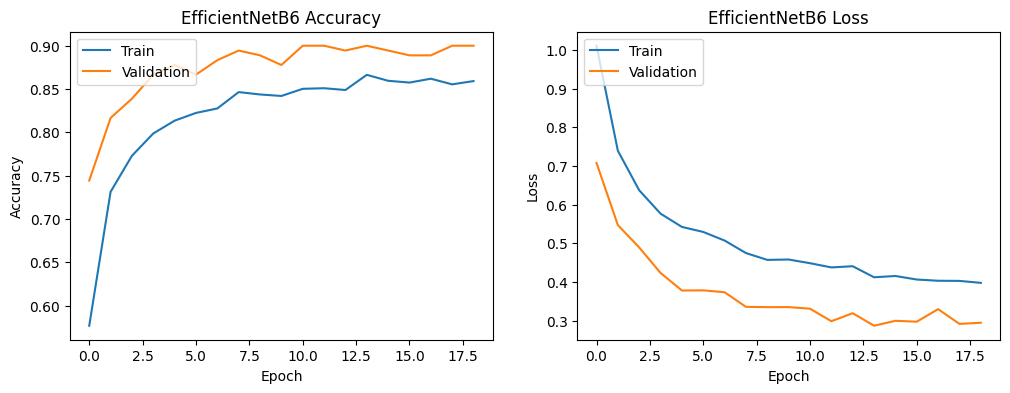

In [ ]:
# # Fungsi untuk membuat dan meng-compile model dengan perbaikan
# def build_and_compile_model(base_model_class, input_shape, num_classes):
#     base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
#     base_model.trainable = False  # Freeze the base model

#     inputs = Input(shape=input_shape)
#     # Tidak perlu preprocessing lagi di sini
#     x = base_model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.5)(x)

#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model


# # Preprocessing functions
# preprocess_funcs = {
#     EfficientNetB0: efficientnet_preprocess,
#     EfficientNetV2B0: efficientnet_v2_preprocess,
# }

# # Pilih model dan fungsi preprocessing yang sesuai
# preprocess_input_func = efficientnet_preprocess

# efficientnet_b6 = build_and_compile_model(EfficientNetB6, input_shape=(600, 600, 3), num_classes=train_generator.num_classes)

# # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
# checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Fungsi untuk melatih model dan menampilkan grafik
# def train_and_plot(model, model_name, train_generator, validation_generator, epochs=20):
#     history = model.fit(
#         train_generator,
#         validation_data=validation_generator,
#         epochs=epochs,
#         callbacks=[checkpoint_callback, early_stopping_callback]
#     )

#     # Plotting hasil
#     plt.figure(figsize=(12, 4))

#     # Plot training & validation accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title(f'{model_name} Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')

#     # Plot training & validation loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title(f'{model_name} Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper left')

#     plt.show()

# train_and_plot(efficientnet_b6, 'EfficientNetB6', train_generator, validation_generator)

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.2680 - loss: 2.3756 - val_accuracy: 0.4333 - val_loss: 1.2941
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.3285 - loss: 2.0781 - val_accuracy: 0.4833 - val_loss: 1.2116
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.4369 - loss: 1.7210 - val_accuracy: 0.6389 - val_loss: 1.0102
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.4690 - loss: 1.5344 - val_accuracy: 0.7722 - val_loss: 0.7544
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.5314 - loss: 1.3108 - val_accuracy: 0.7833 - val_loss: 0.5933
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.6086 - loss: 1.1782 - val_accuracy: 0.8278 - val_loss: 0.5056
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.6340 - loss: 1.0206 - val_accuracy: 0.8444 - val_loss: 0.4401
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.6664 - loss: 0.9404 - val_accuracy: 0.8556 - val_loss: 0.

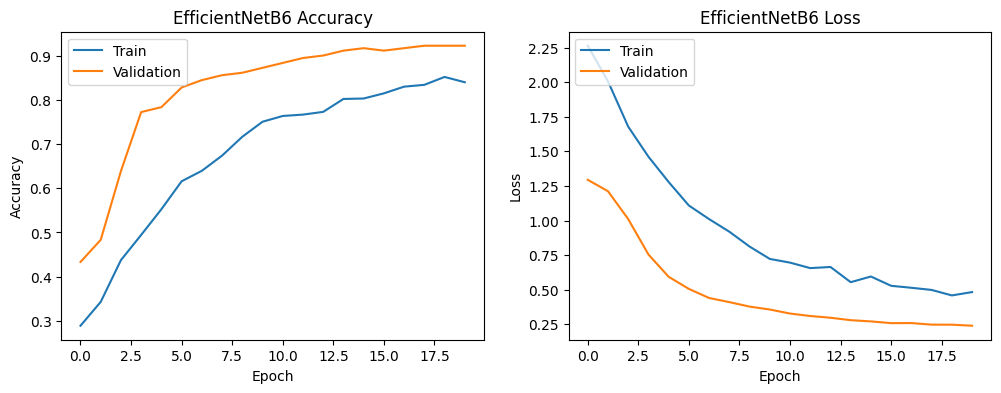

In [ ]:
# Fungsi untuk membuat dan meng-compile model dengan perbaikan
def build_and_compile_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    for layer in base_model.layers[:-100]:
      layer.trainable = False


    inputs = Input(shape=input_shape)
    # Tidak perlu preprocessing lagi di sini
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Preprocessing functions
preprocess_funcs = {
    EfficientNetB0: efficientnet_preprocess,
    EfficientNetV2B0: efficientnet_v2_preprocess,
}

# Pilih model dan fungsi preprocessing yang sesuai
preprocess_input_func = efficientnet_preprocess

efficientnet_b6 = build_and_compile_model(EfficientNetB6, input_shape=(528, 528, 3), num_classes=train_generator.num_classes)

# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi untuk melatih model dan menampilkan grafik
def train_and_plot(model, model_name, train_generator, validation_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Plotting hasil
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

train_and_plot(efficientnet_b6, 'EfficientNetB6', train_generator, validation_generator)